# PlotXspec example

## Basic PyXspec usage & additional plotting

This notebook is aimed at illustrating the _basic_ usage of PyXspec, as well as a few supporting methods related to plotting. The supporting methods are part of the [PlotXspec class available for download here](https://github.com/JohannesBuchner/BXA/tree/master/examples/xspec/bayesian-workflow). The notebook will cover how to load spectra, define a model, fit it to the data, and plot the results. PyXspec makes all Xspec functionality accessible through Python, so covers a much broader range of options than covered here. For further details on PyXspec usage, please see the [documentation](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).

In the following, we will assume a basic familiarity with both Python and Xspec usage. Users will need to have a working HEASOFT installation, as well as a working Python3 installation. The examples focus on the 'out-of-the-box' usage of the PlotXSpec public methods. Some users may find it more helpful to use these methods as a template for their own plotting functions; the PlotXspec class includes several private methods that could also be of use as a guide (such as the ```_get_xspec_data()``` method).

_Please note_: this notebook relates to PyXspec only. For examples of using BXA and the PlotBXA class, please see the notebook [_tutorial_usage_plotbxa_](https://johannesbuchner.github.io/BXA/tutorial_usage_plotbxa.html). 

#### The notebook is structured as follows:
1) Basic loading and plotting data using PyXspec
2) Further plotting examples
3) A slightly more complicated example (multiple spectra & simultaneous fitting)

---
This notebook was tested with:
- HEASOFT 6.33.1
- Python 3.11.4

## 1) Loading and plotting data using PyXspec

We will start with a simple example: loading a single spectrum into Xspec and fitting a model to it. The example data are a NICER spectrum for a bright extragalactic nuclear ignition and the associated background spectrum. The data have been rebinned to a minimum bin count of 20, which means we can use $\chi^2$ statistics.

In [1]:
# Loading the required modules
import xspec
import os,sys

# load the PlotXspec class and create an instance
sys.path.append(os.getcwd()+'/..')
from plot_xspec import PlotXspec
px = PlotXspec()

### A quick aside on getting more information on class methods in Python

If at any point you are unclear about what a method is supposed to do, or what arguments should be passed to it, you can make use of Python's built-in help functionality.

This will list all public methods included in the class:
```python
help(px)
```

And this will show the 'docstring' for a particular method:
```python
help(px.plot_model_and_data)
```

**The public methods in PlotXspec all have docstrings: these explain in more detail what the methods are supposed to and what additional arguments can be passed to make the best use of them.**

### A) Loading

In [2]:
# Global settings for XSpec
xspec.Xset.abund = 'wilm' # Wilms et al. '00'
xspec.Xset.xsect = 'vern' # Verner et al. '96'
xspec.Xset.cosmo = '70 0 0.73' # Flat LambdaCDM

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


In [3]:
# Load the data
#
# In this case we will explicitly set the background, RMF, and ARF in XSPEC
# If all files are linked correctly, this is not necessary as XSPEC loads
# the required files automatically

xspec.AllData.clear() # <= just to be sure there is nothing in the way

olddir = os.getcwd()
os.chdir('example_data/athena/')

sp = xspec.Spectrum('example-file.fak')

os.chdir(olddir)

# NOTE: in our example case, the response file is linked directly
#       from the spetral file. It is, of course, also possible to
#       link these files manually. In PyXspec backround, RMF and 
#       ARF are all atributes of the 'Spectrum' class instance.
# 
# For example (setting background, RMF, and ARF explicitly):
#
#sp.background   = 'path/to/bg_file.bak'
#sp.response     = 'path/to/response_file.rmf'
#sp.response.arf = 'path/to/auxiliary_file.arf'


1 spectrum  in use
 
Spectral Data File: example-file.fak  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.144e+00 +/- 9.104e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-4096
  Telescope: ATHENA+ Instrument: WFI  Channel Type: PI
  Exposure Time: 500 sec
 Using fit statistic: chi
 Using Response (RMF) File            athenapp_ir_b4c_wfi_withfilter_fov40.0arcmin_avg.rsp for Source 1



In [4]:
# The loading above will have caused a few warning messages, but we can check whether
# everything is now in place
xspec.AllData.show()


1 file 1 spectrum 
Spectrum 1  Spectral Data File: example-file.fak
Net count rate (cts/s) for Spectrum:1  4.144e+00 +/- 9.104e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-4096
  Telescope: ATHENA+ Instrument: WFI  Channel Type: PI
  Exposure Time: 500 sec
 Using fit statistic: chi
 Using Response (RMF) File            athenapp_ir_b4c_wfi_withfilter_fov40.0arcmin_avg.rsp for Source 1



In [5]:
# Set the appropriate spectral range
sp.notice('all')
xspec.AllData.ignore('bad')
sp.ignore('**-1.0 10.0-**')

  4096 channels (1,4096) noticed in spectrum #     1




ignore:     0 channels ignored from  source number 1
    93 channels (1-93) ignored in spectrum #     1
  3080 channels (1017-4096) ignored in spectrum #     1



In [6]:
# A final look to make sure everything is in place
xspec.AllData.show()


1 file 1 spectrum 
Spectrum 1  Spectral Data File: example-file.fak
Net count rate (cts/s) for Spectrum:1  4.122e+00 +/- 9.080e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  94-1016
  Telescope: ATHENA+ Instrument: WFI  Channel Type: PI
  Exposure Time: 500 sec
 Using fit statistic: chi
 Using Response (RMF) File            athenapp_ir_b4c_wfi_withfilter_fov40.0arcmin_avg.rsp for Source 1



#################################################################
#### NOTE:
From this point on we will use Python methods  to visualise the data, as implemented in PlotXspec. However, XSpec's normal visualisation can of course also still be used instead. For example, to make use of one of XSpec's plotting windows, enter

```python
xspec.Plot.device = "/xs"
```
and then pass any of XSpec's plotting arguments as strings to xspec.Plot, e.g.
```python
xspec.Plot('ldata')
```
#################################################################

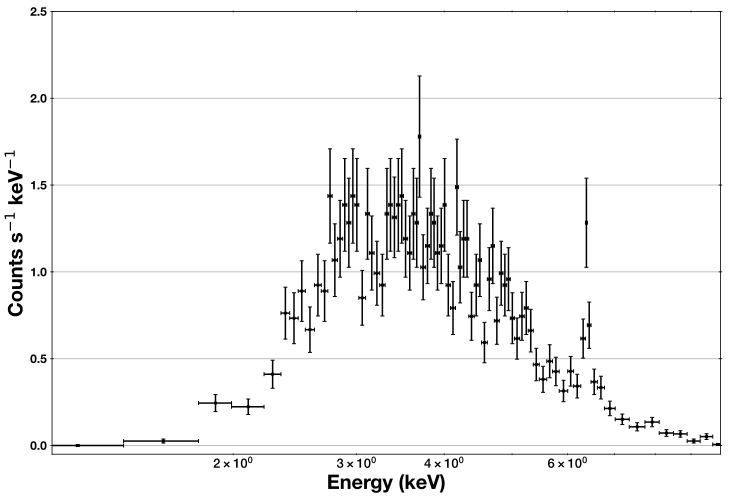

In [7]:
# A first look at the data
px.first_look(ymin=-0.05,ymax=2.5,ylog=False, #<= several keyword arguments can be used, 
              rebinsig=5,rebinbnum=40)        #   to manipulate the plot

### B) Define and fit a model

We will now define a simple model and fit it to the data. For the model, we will use redshifted blackbody, modified by Galactic absorption.

There are many ways to set the parameters in XSpec, and we show only the simplest example here. For a slightly more complex usage, please see section 3) of this notebook.

In [8]:
# The simplest way to define a model in PyXspec
#
# We define the model components and then take a look
# at the parameters we will need to set

xspec.AllModels.clear() # <= just to sure, remove any possible existing definitions
mod = xspec.Model("wabs*pow+gauss") # <= the same model as used to create the spectrum


Model wabs<1>*powerlaw<2> + gaussian<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   gaussian   LineE      keV      6.50000      +/-  0.0          
   5    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   6    3   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


**************************************************************
The wabs model is obsolete and is only included for comparison
with historical results. The tbabs model should be used for
the ISM or phabs for general photoelectric absorption.
**************************************************************

Fit statistic  : Chi-Squared              2

In [9]:
# Now we set each of the parameters to an initial value.
# We can access the models and the parameters by name:
mod.wabs.nH = 1e-2
mod.powerlaw.PhoIndex = 1.7
mod.powerlaw.norm = 1e-4
mod.gaussian.LineE = 6.4
mod.gaussian.Sigma = 0.1
mod.gaussian.norm = 2

# If we want to freeze one of the parameters using 
# this syntax, we could specify, e.g.:
#
# mod.gaussian.LineE.frozen = True


Fit statistic  : Chi-Squared              1.492560e+11     using 923 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared              1.492560e+11     using 923 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 917 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared              1.046520e+11     using 923 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared              1.046520e+11     using 923 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 917 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : Chi-Squared             

In [10]:
# Let us have another look at the model, to make sure
# all parameters are set
xspec.AllModels.show()


Parameters defined:
Model wabs<1>*powerlaw<2> + gaussian<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    1.00000E-02  +/-  0.0          
   2    2   powerlaw   PhoIndex            1.70000      +/-  0.0          
   3    2   powerlaw   norm                1.00000E-04  +/-  0.0          
   4    3   gaussian   LineE      keV      6.40000      +/-  0.0          
   5    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   6    3   gaussian   norm                2.00000      +/-  0.0          
________________________________________________________________________



In [11]:
# Now we can run the fit

# some fitting meta-parameters
xspec.Fit.statMethod = 'chi'
xspec.Fit.nIterations = 1000
# and run...
xspec.Fit.perform()

Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

Fit statistic  : Chi-Squared              1.161918e+10     using 923 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared              1.161918e+10     using 923 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 0.000000e+00 with 917 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl          1:nH    2:PhoIndex        3:norm       4:LineE       5:Sigma        6:norm
1961.41      181916       -2   4.40138e-05      -1.63105   1.78908e-09       6.40276      0.110236   0.000173015
1559.05      1.09745e+07   0   1.80951e-05      -2.34265   4.07536e-06       6.40249     0.0979004   0.000139696
1395.23      1.64224e+07  -1   

In [12]:
# With the fit completed, we can access the usual functionalities in XSpec
xspec.AllModels.calcFlux("1.0,10.0")

 Model Flux 0.0015144 photons (1.3645e-11 ergs/cm^2/s) range (1.0000 - 10.000 keV)


In [13]:
# Should we want to look at the scaling factor from rate to flux, we could do the following
print(f'scaling rate (1-10keV) = {sp.flux[0]/sp.rate[0]:.3e}')

scaling rate (1-10keV) = 3.310e-12


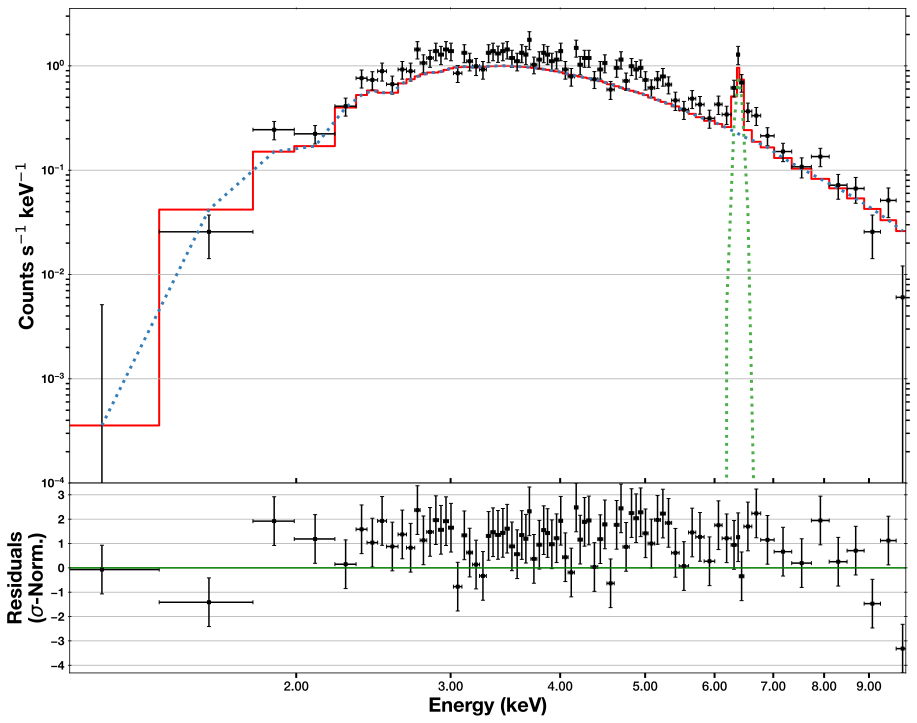

In [14]:
# And we can look at the resulting fit
px.plot_model_and_data(ymin=1e-4,rebinsig=5,rebinbnum=40)

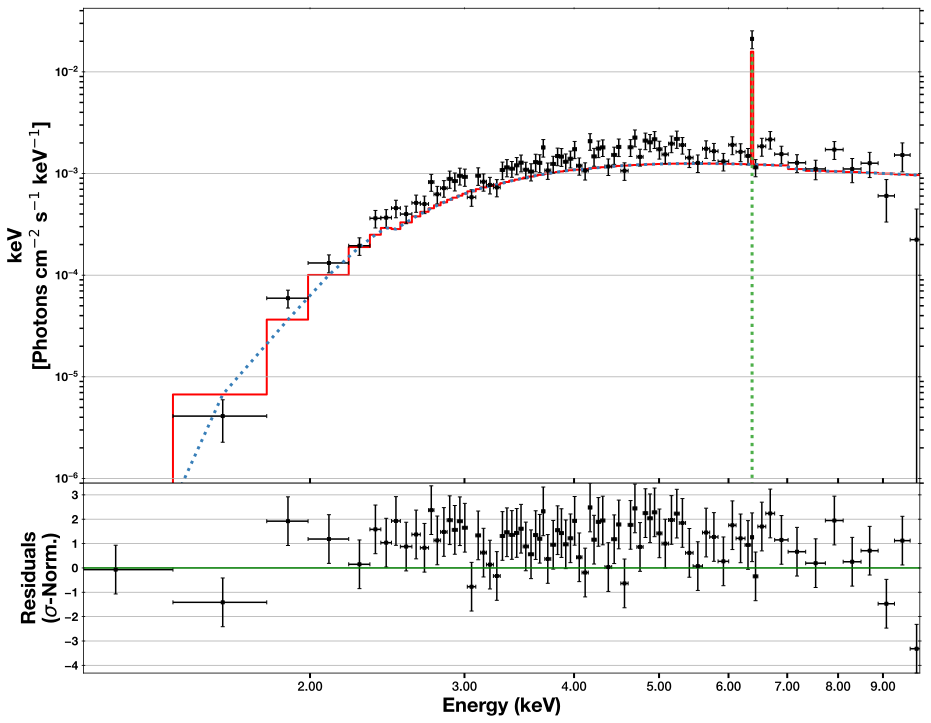

In [15]:
# If we, e.g., would like to look at the unfolded spectrum,
# we can specify the 'plottype' keyword argument.
px.plot_model_and_data(ymin=9e-7,rebinsig=5,rebinbnum=40,plottype='unfolded')

##################

PlotXspec also includes two methods to print a quick overview of the fitting results to screen: print_model_results() & print_errors(). The print_errors method requires the user to specify the $\chi^2$ level for which the errors should be calculated. Of course, if the overall $\chi^2$ statistic for the fit is too high, no error can be calculated (as XSpec raises an exception).

In [16]:
px.print_model_results()


Components of model  for data group 1:
1   wabs              nH            9.27992e+00 +/- 7.11625e-01  10^22
2   powerlaw          PhoIndex      1.71797e+00 +/- 1.96798e-01       
3   powerlaw          norm          5.46374e-03 +/- 1.81938e-03       
4   gaussian          LineE         6.40210e+00 +/- 4.45308e-02    keV
5   gaussian          Sigma         6.71861e-05 +/- 2.13313e-02    keV
6   gaussian          norm          8.89162e-05 +/- 1.54284e-05       
---
Fit statistic: chi
Test statistic: 605.25
Reduced chi-squared: 605.25/917 = 0.66


In [17]:
px.print_errors(1.0)


Components of model  for data group 1:
1   wabs       nH         9.280e+00 (-)-5.929e-01 (+)1.251e+00
2   powerlaw   PhoIndex   1.991e+00 (-)2.080e-01 (+)2.220e-01


3   powerlaw   norm       8.677e-03 (-)2.566e-03 (+)3.946e-03
Continue error search in this direction? 

4   gaussian   LineE      6.402e+00 (-)2.004e-02 (+)9.521e-03
5   gaussian   Sigma      3.021e-02 (-)0.000e+00 (+)4.808e-02
6   gaussian   norm       9.680e-05 (-)1.745e-05 (+)1.699e-05


##  2)  Further Plotting Examples

In some cases, it can be usefule to explore the parameter space of a model, to get a better understanding of the distribution of $\chi^2$, and therefore of the uncertainties. We can do this with steppar. The command for steppar is passed as a string and is the same as it would be in XSpec (we can see what the indices are for the model parameters of interest using e.g. the output of print_model_results or xspec.AllModels.show() ).

In [18]:
# when running in Jupyer notebooks, it can be helpful to reduce the log-output here (especially for steppar)
# -- BXA's 'XSilence' method is helpful for this too --
xchat = xspec.Xset.chatter, xspec.Xset.logChatter
xspec.Xset.chatter    = 0
xspec.Xset.logChatter = 0

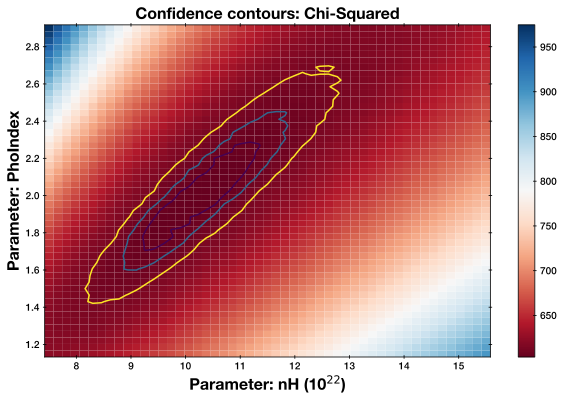

In [19]:
# run steppar and plot. Here we vary parameters 1 (nH) and 2 (Gamma)
xspec.Fit.steppar('1 7.5 15.5 50 2 1.15 2.9 50')
px.plot_chisq_contours()

If it is only a single parameter we are interested in, we should consider the 1-dimensional $\chi^2$ distribution. By passing the best-fit value of a particular parameter (in the example below: kT), we can get an estimate on the error in this way.

Resulting uncertainties: 2.01334e+00 (-) 2.13237e-01 (+) 2.23663e-01


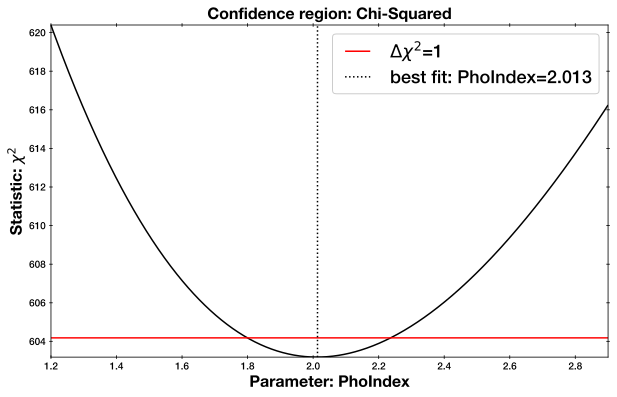

In [20]:
par = mod.powerlaw.PhoIndex   #<= the parameter of interest
xspec.Fit.steppar('2 1.2 2.9 1000')
px.calc_error_from_1Dchisq(par,level=1)

In [21]:
# set XSpec's outbut levels back to their original values
xspec.Xset.chatter, xspec.Xset.logChatter = xchat

In [22]:
# Note that the error value is above is different from the initial estimate shown in the
# fitting results overview (see output below). This is because the method used above 
# provided a different (more refined) approach for the calculation of the uncertainties
xspec.AllModels.show()


Parameters defined:
Model wabs<1>*powerlaw<2> + gaussian<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   wabs       nH         10^22    10.2510      +/-  0.785613     
   2    2   powerlaw   PhoIndex            2.01334      +/-  0.215426     
   3    2   powerlaw   norm                8.98510E-03  +/-  3.26145E-03  
   4    3   gaussian   LineE      keV      6.40175      +/-  1.47760E-02  
   5    3   gaussian   Sigma      keV      3.02129E-02  +/-  2.24204E-02  
   6    3   gaussian   norm                9.67993E-05  +/-  1.74341E-05  
________________________________________________________________________



## 3) More detailed fitting example (XMM-Newton: pn, MOS1, and MOS2)

When fitting multiple datasets simultaneously, we need to slightly adjust our fitting procedure. In the following we will load XMM-Newton data from all three EPIC instruments. To account for a possible offset in the flux level between the spectra, we will multiply our model with a constant factor, which will be allowed to vary among the spectra. All other model parameters will remain tied.

The example data used here are for an AGN showing intrinsic obscuration and a weak Iron K$\alpha$ line. We will fit these data with a redshifted power-law model, modified with both intrinsic and Galactic absorption.

In [23]:
# Load the data
xspec.AllData.clear()
xspec.AllModels.clear()

olddir = os.getcwd()
os.chdir('example_data/xmm/')

epicfn = 'epic_pn_agn.fak'
mos1fn = 'epic_mos1_agn.fak'
mos2fn = 'epic_mos2_agn.fak'

# load into different data groups
xspec.AllData(f"1:1 {epicfn} 2:2 {mos1fn} 3:3 {mos2fn}")

os.chdir(olddir)

# Spectral range
xspec.AllData.notice('all')
xspec.AllData.ignore('bad')
for ii in range(1,4):
    xspec.AllData(ii).ignore('**-0.2 10.0-**')

***Warning: Detected response matrix energy bin value = 0 (or neg).
     XSPEC will instead use small finite value (response file will not be altered).
***Warning: Detected response matrix energy bin value = 0 (or neg).
     XSPEC will instead use small finite value (response file will not be altered).

3 spectra  in use
 
Spectral Data File: epic_pn_agn.fak  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.544e-02 +/- 1.144e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-4096
  Telescope: XMM Instrument: EPN  Channel Type: PI
  Exposure Time: 5e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File            epic_pn.rsp for Source 1

Spectral Data File: epic_mos1_agn.fak  Spectrum 2
Net count rate (cts/s) for Spectrum:2  6.234e-02 +/- 1.117e-03
 Assigned to Data Group 2 and Plot Group 2
  Noticed Channels:  1-800
  Telescope: XMM Instrument: EMOS1  Channel Type: PI
  Exposure Time: 5e+04 sec
 Using fit statistic: chi
 Using Response (RMF) File          

    14 channels (1-14) ignored in spectrum #     3
   134 channels (667-800) ignored in spectrum #     3



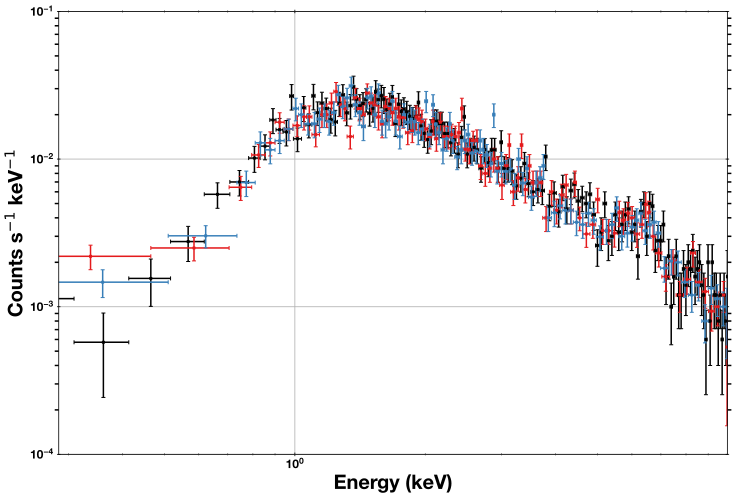

In [24]:
# A first look at the data
px.first_look(ymin=1e-4,ymax=1e-1,rebinsig=5,rebinbnum=20)

In [25]:
# Set all necessary parameters in XSpec & define the model
#
# In the simulated data, there is an offset in flux between the pn and the
# MOS1 & MOS2 spectra. We will account for this using multiplicative
# constant in the model. In the model definition, we need to make sure only
# the 'constant' factor is allowed to vary for the MOS1 & MOS2 spectra, 
# w.r.t. the pn spectrum. All other parameters should remain tied together.

## initial settings
xspec.Xset.abund = 'wilm' # Wilms et al. '00'
xspec.Xset.xsect = 'vern' # Verner et al. '96'
xspec.Xset.cosmo = '70 0 0.73'

z_opt = 0.015 # assume this is known

xspec.Fit.statMethod = 'chi'

## define model
xspec.AllModels += ("constant(zTBabs*(zpowerlw))")
mod = xspec.AllModels(1)  # <= we explicitly set mod to the first of the models 
                          #   (XSspec has now loaded three, one for each spectrum)

# Let us have a first look
# xspec.AllModels.show() # <= only necessary if the model is not automatically printed below

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.

Model constant<1>(zTBabs<2>*zpowerlw<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
                           Data group: 1
   1    1   constant   factor              1.00000      +/-  0.0          
   2    2   zTBabs     nH         10^22    1.00000      +/-  0.0          
   3    2   zTBabs     Redshift            0.0          frozen
   4    3   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   5    3   zpowerlw   Redshift            0.0          frozen
   6    3   zpowerlw   norm                1.00000      +/-  0.0          
                           Data group: 2
   7    1   co

In [26]:
# Silence XSpec for the moment...
xchat = xspec.Xset.chatter, xspec.Xset.logChatter
xspec.Xset.chatter    = 0
xspec.Xset.logChatter = 0

# Set parameter definitions
mod.constant.factor.values   = (1,-1)                           #<= note the different notation here; 
                                                                #   1 is the initial value, -1 means frozen
mod.zTBabs.Redshift.values   = (z_opt, -1.)
mod.zTBabs.nH.values         = (1., 0.01, 1e-3, 1e-3, 10., 10.) #<= standard XSpec syntax for parameter definition

mod.zpowerlw.PhoIndex.values = (1.8, 0.1, -0.5, -0.5, 5., 5.)
mod.zpowerlw.Redshift.values = (z_opt, -1)
mod.zpowerlw.norm.values     = (1.e-1, 0.01, 1.e-5, 1.e-5, 1e1, 1e1)

# Below we untie the model parameters for the MOS data. As noted,
# there are in fact three models (one per data group). In PyXspec
# we can access each model by its index in the AllModels object.
# Below, we first untie the contant parameter from its counterpart
# in the first model and then unfreeze it, by giving it a possible
# range of values.
xspec.AllModels(2).constant.factor.untie()
xspec.AllModels(2).constant.factor.values = (1, 0.01, 0.5, 0.5, 1.5, 1.5)
xspec.AllModels(3).constant.factor.untie()
xspec.AllModels(3).constant.factor.values = (1, 0.01, 0.5, 0.5, 1.5, 1.5)

# ... and show XSpec output again
xspec.Xset.chatter, xspec.Xset.logChatter = xchat

# Let's have another look at the models now
xspec.AllModels.show()


Parameters defined:
Model constant<1>(zTBabs<2>*zpowerlw<3>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
                           Data group: 1
   1    1   constant   factor              1.00000      frozen
   2    2   zTBabs     nH         10^22    1.00000      +/-  0.0          
   3    2   zTBabs     Redshift            1.50000E-02  frozen
   4    3   zpowerlw   PhoIndex            1.80000      +/-  0.0          
   5    3   zpowerlw   Redshift            1.50000E-02  frozen
   6    3   zpowerlw   norm                0.100000     +/-  0.0          
                           Data group: 2
   7    1   constant   factor              1.00000      +/-  0.0          
   8    2   zTBabs     nH         10^22    1.00000      = p2
   9    2   zTBabs     Redshift            1.50000E-02  = p3
  10    3   zpowerlw   PhoIndex            1.80000      = p4
  11    3   zpowerlw   Redshift            1.50000E-02  = p5
  12    3   zpowerlw   norm          

In [27]:
# now we can run the fit
xspec.Fit.perform()

                                   Parameters
Chi-Squared  |beta|/N    Lvl          2:nH    4:PhoIndex        6:norm      7:factor     13:factor
2414.85      125          -3       1.01649       2.04219     0.0780821       1.07293       1.08391
2411.68      169.882      -4       1.06261       2.09345     0.0831957       1.08686       1.10103
2411.64      30.1453      -5       1.06119       2.09449     0.0832545       1.08887       1.10317
2411.64      0.0665746    -6       1.06158       2.09488     0.0832932       1.08892       1.10324
 Variances and Principal Axes
                 2        4        6        7       13  
 1.0167E-06|  0.0398   0.0692  -0.9961  -0.0268  -0.0268  
 2.4296E-04|  0.7445  -0.6670  -0.0174   0.0104   0.0220  
 5.0156E-04| -0.0071   0.0040   0.0003  -0.7136   0.7005  
 1.6669E-03|  0.2722   0.2704   0.0647  -0.6459  -0.6568  
 2.1798E-03|  0.6083   0.6908   0.0576   0.2697   0.2769  
------------------------------------------------------------

  Covariance Ma

  zpowerlw   norm                8.32932E-02  +/-  3.91112E-03  
                           Data group: 2
   7    1   constant   factor              1.08892      +/-  3.33077E-02  
   8    2   zTBabs     nH         10^22    1.06158      = p2
   9    2   zTBabs     Redshift            1.50000E-02  = p3
  10    3   zpowerlw   PhoIndex            2.09488      = p4
  11    3   zpowerlw   Redshift            1.50000E-02  = p5
  12    3   zpowerlw   norm                8.32932E-02  = p6
                           Data group: 3
  13    1   constant   factor              1.10324      +/-  3.36528E-02  
  14    2   zTBabs     nH         10^22    1.06158      = p2
  15    2   zTBabs     Redshift            1.50000E-02  = p3
  16    3   zpowerlw   PhoIndex            2.09488      = p4
  17    3   zpowerlw   Redshift            1.50000E-02  = p5
  18    3   zpowerlw   norm                8.32932E-02  = p6
________________________________________________________________________


Fit statistic  : C

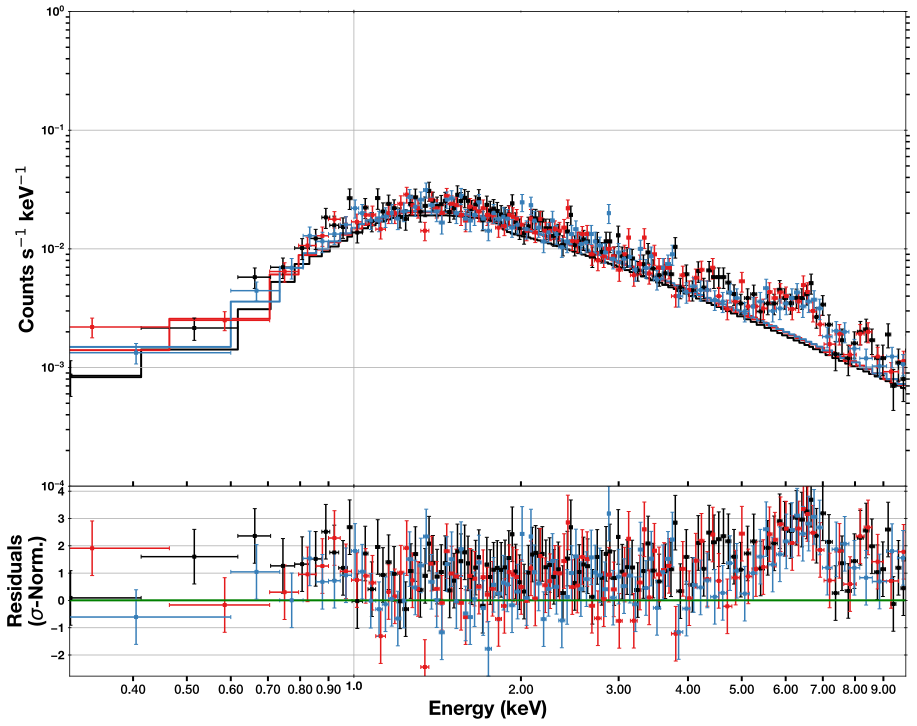

In [28]:
# ... and plot the results
px.plot_model_and_data(ymin=1e-4,ymax=1,rebinsig=5,rebinbnum=40)

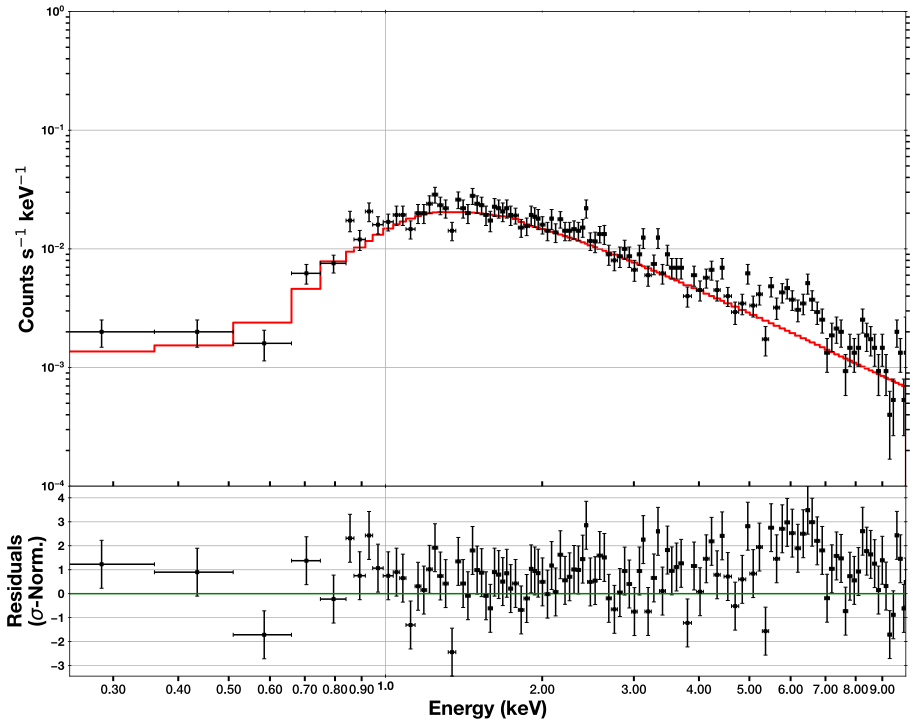

In [29]:
# or if we want to look at e.g. only the MOS1 spectrum
px.plot_model_and_data(ymin=1e-4,ymax=1,idsp=2,rebinsig=5)

In [30]:
# A quick overview of the fit results
px.print_model_results()


Components of model  for data group 1:
1   constant          factor        1.00000e+00 +/- 0.00000e+00       
2   zTBabs            nH            1.06158e+00 +/- 3.26316e-02  10^22
3   zTBabs            Redshift      1.50000e-02 +/- 0.00000e+00       
4   zpowerlw          PhoIndex      2.09488e+00 +/- 3.56397e-02       
5   zpowerlw          Redshift      1.50000e-02 +/- 0.00000e+00       
6   zpowerlw          norm          8.32932e-02 +/- 3.91112e-03       
---
Fit statistic: chi
Test statistic: 2411.64
Reduced chi-squared: 2411.64/3260 = 0.74

Components of model  for data group 2:
7   constant          factor        1.08892e+00 +/- 3.33077e-02       
8   zTBabs            nH            1.06158e+00 +/- 0.00000e+00  10^22
9   zTBabs            Redshift      1.50000e-02 +/- 0.00000e+00       
10  zpowerlw          PhoIndex      2.09488e+00 +/- 0.00000e+00       
11  zpowerlw          Redshift      1.50000e-02 +/- 0.00000e+00       
12  zpowerlw          norm          8.32932e-02 +/-

In [31]:
# ... and of the errors
px.print_errors(1.0)


Components of model  for data group 1:
1   constant   factor     1.000e+00 (-)0.000e+00 (+)0.000e+00
2   zTBabs     nH         1.062e+00 (-)3.108e-02 (+)3.211e-02
3   zTBabs     Redshift   1.500e-02 (-)0.000e+00 (+)0.000e+00
4   zpowerlw   PhoIndex   2.095e+00 (-)3.591e-02 (+)3.649e-02
5   zpowerlw   Redshift   1.500e-02 (-)0.000e+00 (+)0.000e+00
6   zpowerlw   norm       8.329e-02 (-)3.744e-03 (+)3.944e-03

Components of model  for data group 2:
7   constant   factor     1.089e+00 (-)3.291e-02 (+)3.403e-02
8   zTBabs     nH         1.062e+00 (-)0.000e+00 (+)0.000e+00
9   zTBabs     Redshift   1.500e-02 (-)0.000e+00 (+)0.000e+00
10  zpowerlw   PhoIndex   2.095e+00 (-)0.000e+00 (+)0.000e+00
11  zpowerlw   Redshift   1.500e-02 (-)0.000e+00 (+)0.000e+00
12  zpowerlw   norm       8.329e-02 (-)0.000e+00 (+)0.000e+00

Components of model  for data group 3:
13  constant   factor     1.103e+00 (-)3.328e-02 (+)3.441e-02
14  zTBabs     nH         1.062e+00 (-)0.000e+00 (+)0.000e+00
15  zTBabs  